In [116]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [117]:
!pip install supervision -q

In [118]:
!mkdir -p weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P weights

In [119]:
!pip install jupyter-bbox-widget  -q
!jupyter nbextension enable --py --sys-prefix jupyter-bbox-widget

Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbextension", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/jupyter_core/application.py", line 283, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/notebook/nbextensions.py", line 972, in start
    super().start()
  File "/usr/local/lib/python3.10/dist-packages/jupyter_core/application.py", line 270, in start
    self.subapp.start()
  File "/usr/local/lib/python3.10/dist-packages/notebook/nbextensions.py", line 882, in start
    self.toggle_nbextension_python(self.extra_args[0])
  File "/usr/local/lib/python3.10/dist-packages/notebook/nbextensions.py", line 855, in toggle_nbextension_python
    return toggle(module,
  File "/usr/local/lib/python3.10/dist-packages/notebook/nbextensions.py

In [120]:
import torch
import cv2
import base64
import numpy as np
import supervision as sv
import warnings
warnings.filterwarnings("ignore")
from google.colab import output
output.enable_custom_widget_manager()
from jupyter_bbox_widget import BBoxWidget
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [121]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [122]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [123]:
sam = sam_model_registry["vit_h"](checkpoint="weights/sam_vit_h_4b8939.pth").to(device=DEVICE)

In [124]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [125]:
image_path = "/content/pet (1).jpg"
image_bgr = cv2.imread(image_path)
# image_rgb =  # your code
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
sam_result = mask_generator.generate(image_rgb)

(533, 800, 3)


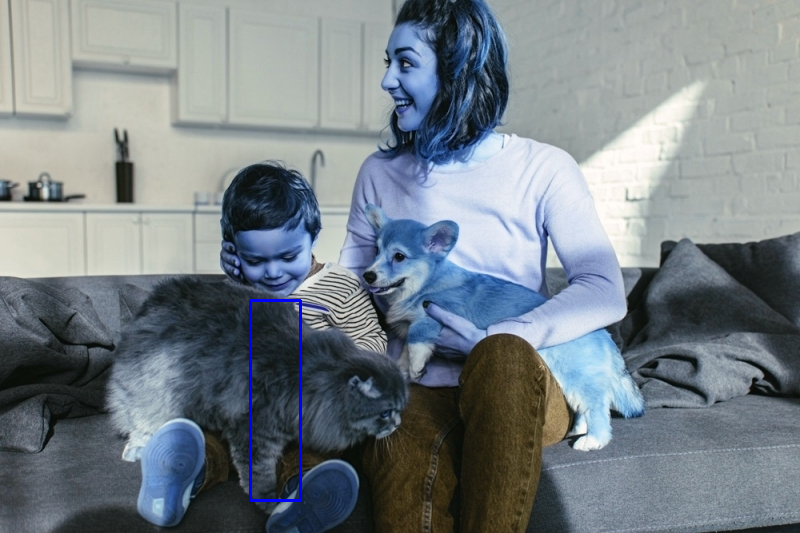

In [126]:

from google.colab.patches import cv2_imshow
image_path = "/content/pet (1).jpg"
image_bgr = cv2.imread(image_path)

start_point = (250, 300)  # (x, y) coordinates of the top-left corner
end_point = (300, 500)    # (x, y) coordinates of the bottom-right corner
color = (255, 0, 0)       # BGR format: (Blue, Green, Red)
thickness = 2             # Line thickness in pixels

# Draw the rectangle on the image
image_with_rectangle = cv2.rectangle(image_rgb, start_point, end_point, color, thickness)
print(image_rgb.shape)
# Display the image with the rectangle
cv2_imshow(image_with_rectangle)
cv2.waitKey(0)
cv2.destroyAllWindows()



In [127]:
sam_result[0].keys()

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])

use this [link](https://supervision.roboflow.com/latest/detection/annotators/#supervision.annotators.core.MaskAnnotator.annotate)

In [128]:
# mask_annotator = # your code

# detections = # your code

# annotated_image = # your code

mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

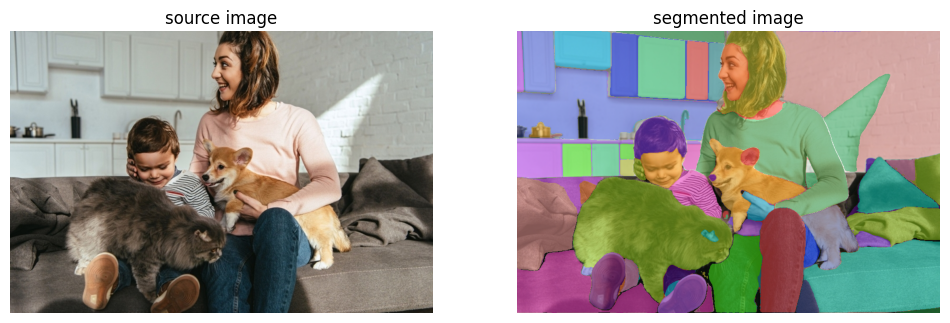

In [129]:
sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

82


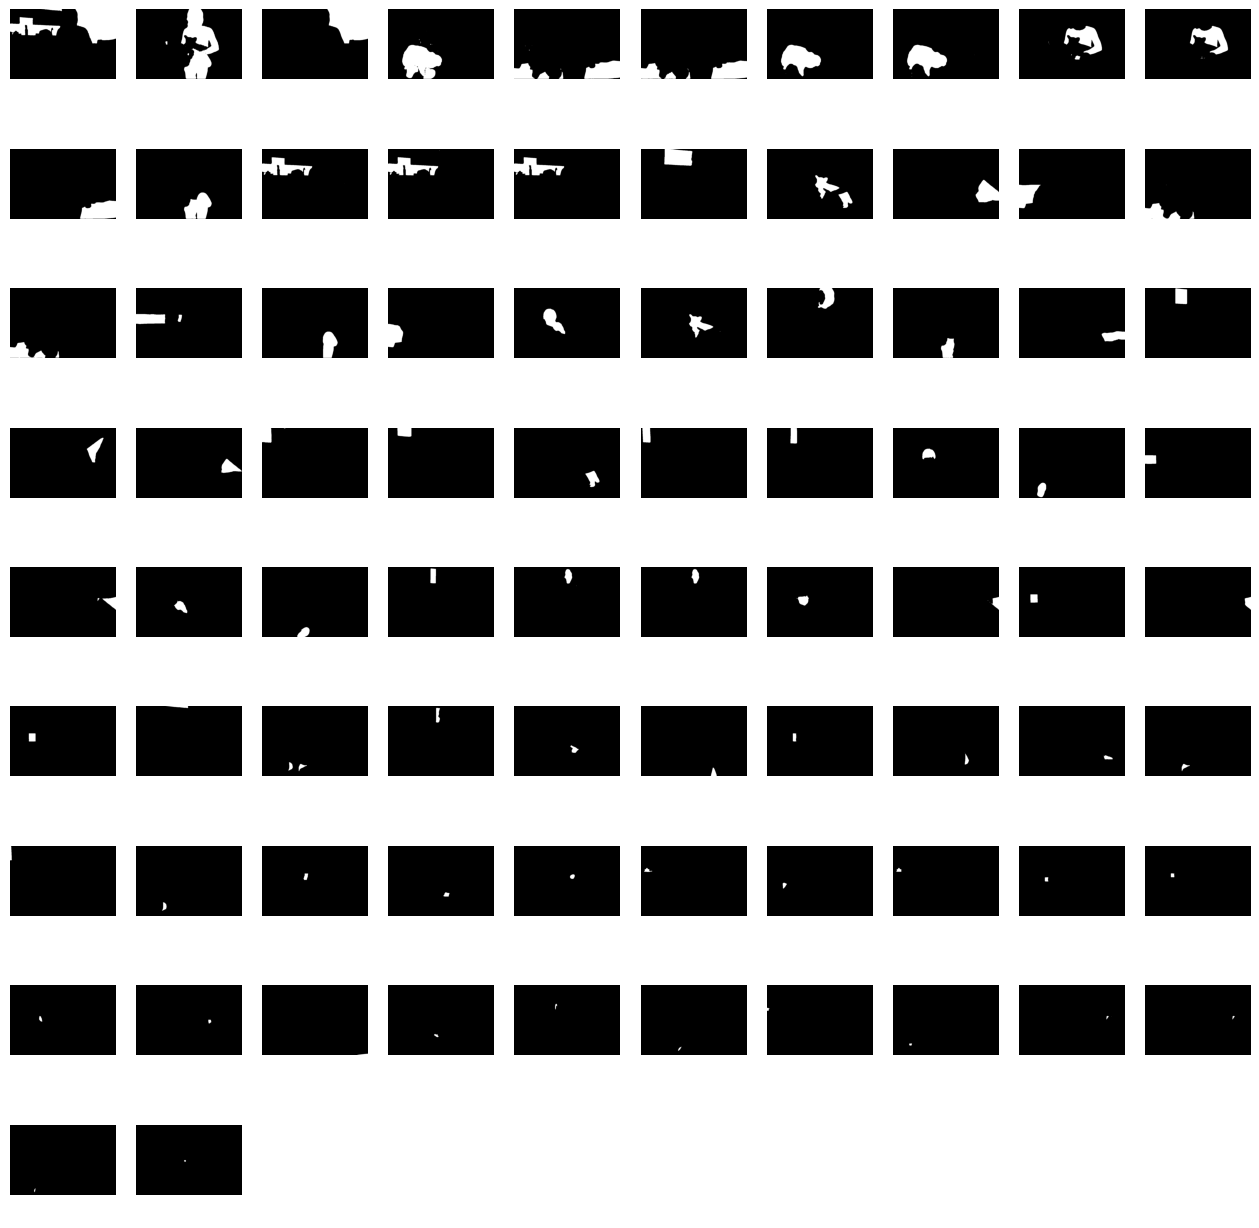

In [130]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]
print(len(masks))
sv.plot_images_grid(
    images=masks,
    grid_size=(9, int(len(masks) / 8)),
    size=(16, 16)
)

In [131]:
mask_predictor = SamPredictor(sam)

In [132]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded


# helper function that loads an image before adding it to the widget

In [133]:
import os
IMAGE_NAME = "pet (1).jpg"
IMAGE_PATH = os.path.join(os.getcwd(), IMAGE_NAME)

IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget


BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [134]:
image_bgr.shape

(533, 800, 3)

In [135]:
# box = # your code

widget.bboxes

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 100, 'width': 533, 'height': 800, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
print(box)
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])
print(box)

{'x': 68, 'y': 100, 'width': 533, 'height': 800, 'label': ''}
[ 68 100 601 900]


In [136]:
widget.bboxes


[]

In [ ]:
mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(box=box,multimask_output=True)

In [ ]:
# box_annotator = # your code
# mask_annotator = # your code

box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

# source_image = # your code
# segmented_image = # your code
source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [ ]:
sv.plot_images_grid(
    images=masks,
    grid_size=(1, 3),
    size=(16, 4)
)